In [1]:
import os
import pandas as pd
import numpy as np
import torch
import datetime as dt
import torch.nn as nn
from torchdiffeq import odeint_adjoint as odeint
import csv
from pathlib import Path
from scipy import signal
from ipywidgets import interact
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import random

import torch.nn.functional as F

In [2]:
df = pd.read_csv(os.path.join(os.getcwd(), "results", "Full_experts_check.csv")).set_index("ID")
icps = []
abps = []
for row in df.iterrows():
    row = row[1]
    icp = row["icp_full"][1:-1].replace(",","").split(" ")
    icp = [float(value.strip("\n")) for value in icp if value is not ""]
    icps.append(icp)
#     print(len(icp))
    abp = row["abp_full"][1:-1].replace(",","").split(" ")
    abp = [float(value.strip("\n")) for value in abp if value is not ""]
#     print(len(abp))
    abps.append(abp)
ICP_full = torch.tensor(icps ,dtype=torch.float)
ABP_full = torch.tensor(abps,dtype=torch.float)

In [3]:
excluded_prefix = "pretraining"
prefixes = ["_Tryout_", "_Training_Artificial_AE_", "_Training_", "__", "_pretrained_"]
suffixes = ["unfrozen", "pretrained"]
folders = os.listdir(os.path.join(os.getcwd(),"experiments"))

In [4]:
def find_model_info(name, experiments):
    for experiment in experiments:
        if name == experiment["name_full"]:
            return {
                "model": experiment["model"],
                "o2pfcn": experiment["manager"]["o2p_fcn"],
                "input_preprocessing": experiment["manager"]["input_preprocessing"],
                "siamese": experiment["dataset"]["siamese"],
                "additional": experiment["dataset"]
            }

In [27]:
folders

['2021-01-02_Tryout_ResNet_1',
 '2021-01-02_Tryout_ResNet_d5_1',
 '2021-01-02_Tryout_ResNet_d4_1',
 '2021-01-02_Tryout_ResNet_d3_1',
 '2021-01-02_Tryout_ResNet_d2_1',
 '2021-01-02_Tryout_ResNet_d1_1']

In [28]:
import re
output_dataframe_dict = {}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
counter = 6
for folder in tqdm(folders):
    experiment_name = folder
    name = re.sub(r'\d+-\d+-\d+', '', folder)
    name = re.sub(r'\d+', '', name)
    if excluded_prefix not in name:
        for prefix in prefixes:
            name = name.replace(prefix,"")
        for suffix in suffixes:
            name = name.replace(suffix,"")
        name = name.strip("_")
        if counter <= 5:
            name = name + str(counter)
        print(name)
        counter -= 1
        model_info = find_model_info(name, experiments)
        model_path = os.path.join(os.getcwd(), "experiments", experiment_name, "model_best.pth")
        model = model_info["model"].to(device)
        model.load_state_dict(torch.load(model_path, map_location=device)["state_dict"])
        model.eval()

        if model_info["siamese"]:
            model_input = [ICP_full.to(device), ABP_full.to(device)]
        else:
            model_input = [ICP_full.to(device)]

        if model_info["input_preprocessing"] is not None:
            input_preprocessing = model_info["input_preprocessing"]
        else:
            input_preprocessing = lambda x: x

        if model_info["o2pfcn"] is not None:
            output_to_pred_fcn = model_info["o2pfcn"]
        else:
            output_to_pred_fcn = lambda x: x

        model_input = input_preprocessing(model_input)
        outputs = model(*model_input)
        predicted = output_to_pred_fcn(outputs)
        output_dataframe_dict[experiment_name] = predicted

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 55.80it/s]

ResNet
ResNet_d5
ResNet_d4
ResNet_d3
ResNet_d2
ResNet_d1


In [29]:
output_dataframe_dict["ID"] = list(range(len(df)))
for key in output_dataframe_dict.keys():
    data = output_dataframe_dict[key]
    if not isinstance(data, list):
#         output_dataframe_dict[key] = numpy.split(data, 650)
        if len(data.shape) > 1:
            output_dataframe_dict[key] = [a[0] for a in np.split(data, 650)]
df_pred = pd.DataFrame(output_dataframe_dict).set_index("ID")

In [30]:
scoring_df = df.join(df_pred)
scoring_df = scoring_df.rename(columns = {"Likely type": "Likely", "Possible type": "Possible"}, inplace = False)

In [31]:
scoring_df

,Likely,Possible,abp_full,icp_full,2021-01-02_Tryout_ResNet_1,2021-01-02_Tryout_ResNet_d5_1,2021-01-02_Tryout_ResNet_d4_1,2021-01-02_Tryout_ResNet_d3_1,2021-01-02_Tryout_ResNet_d2_1,2021-01-02_Tryout_ResNet_d1_1
ID,,,,,,,,,,
0,1,1,[3.04814486e-02 2.18967845e-02 1.42104387e-02 ...,[5.81779680e-03 1.87093060e-03 0.00000000e+00 ...,4,0,0,0,0,0
1,2,2,[0.02428143 0.01584578 0.00807451 0.00233634 0...,[6.47123462e-02 5.54119309e-02 4.46266755e-02 ...,2,2,2,2,2,2
2,2,2,[1.59646774e-01 1.43772435e-01 1.28992707e-01 ...,[0.01877641 0.01091759 0.00506625 0.00137589 0...,1,1,1,1,1,3
3,1,1,[5.52120121e-02 4.58446053e-02 3.61205810e-02 ...,[2.67341992e-02 2.06881025e-02 1.48638903e-02 ...,0,0,0,0,0,0
4,3,3,[0.04620486 0.06037026 0.07319366 0.08527039 0...,[1.48506940e-02 1.06446098e-02 6.36478001e-03 ...,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...
645,2,2,"[0.0017795, 0.0, 0.01063416, 0.01229615, 0.018...","[0.0, 0.00363864, 0.01151878, 0.02390274, 0.04...",1,1,1,1,1,1
646,3,3,"[0.0, 0.00449792, 0.00149089, 0.02160732, 0.03...","[0.03117772, 0.03105301, 0.03702201, 0.0494947...",2,2,2,4,4,2
647,2,4,"[0.00843174, 0.00791627, 0.00437937, 0.0046104...","[0.0, 0.0012543, 0.00611003, 0.01476069, 0.027...",3,3,3,3,3,1


In [32]:
rights = []
names = scoring_df.columns[4:]
for i in range(len(names)):
    right = 0
    if "Multilabel" in names[i]:
        true_labels = scoring_df["Likely"].values
        possible_labels = scoring_df["Possible"].values
        predicted_labels = scoring_df[names[i]].values
        for true, possible, predicted in zip(true_labels, possible_labels, predicted_labels):
            if predicted[true-1] == 1 or predicted[possible-1] == 1:
                right+=1
    else:
        right = len(scoring_df.loc[scoring_df["Likely"] == scoring_df[names[i]] + 1])
        right += len(scoring_df.loc[scoring_df["Possible"] == scoring_df[names[i]] + 1].loc[scoring_df["Possible"] != scoring_df["Likely"]])
#         right = len(scoring_df.query('`Likely` == `' + names[i] + '` + 1 or `Possible` == `' + names[i] + '` + 1'))     
    rights.append(right)

In [33]:
for name,right in zip(names, rights):
    print("{} : {:2.2f} %".format(name, right/650*100))

2021-01-02_Tryout_ResNet_1 : 80.46 %
2021-01-02_Tryout_ResNet_d5_1 : 80.62 %
2021-01-02_Tryout_ResNet_d4_1 : 82.92 %
2021-01-02_Tryout_ResNet_d3_1 : 80.15 %
2021-01-02_Tryout_ResNet_d2_1 : 81.85 %
2021-01-02_Tryout_ResNet_d1_1 : 82.15 %


In [146]:
save_df = {"names": names,
          "best_accuracy": np.array(rights)/650*100}
pd.DataFrame(save_df).to_csv(os.path.join(os.getcwd(), "results", "final_experts_scoring_best.csv"))

In [138]:
print(max(rights)/650)

0.86


In [34]:
rights = []
names = scoring_df.columns[4:]
for i in range(len(names)):
    right = 0
    if "Multilabel" in names[i]:
        true_labels = scoring_df["Likely"].values
        possible_labels = scoring_df["Possible"].values
        predicted_labels = scoring_df[names[i]].values
        for true, possible, predicted in zip(true_labels, possible_labels, predicted_labels):
            if predicted[true-1] == 1 and predicted[possible-1] == 1:
                right+=1
    else:
        right = len(scoring_df.loc[scoring_df["Likely"] == scoring_df[names[i]] + 1])
#         right += len(scoring_df.loc[scoring_df["Possible"] == scoring_df[names[i]] + 1].loc[scoring_df["Possible"] != scoring_df["Likely"]])
#         right = len(scoring_df.query('`Likely` == `' + names[i] + '` + 1 or `Possible` == `' + names[i] + '` + 1'))     
    rights.append(right)

In [35]:
for name,right in zip(names, rights):
    print("{} : {:2.2f} %".format(name, right/650*100))

2021-01-02_Tryout_ResNet_1 : 76.31 %
2021-01-02_Tryout_ResNet_d5_1 : 76.15 %
2021-01-02_Tryout_ResNet_d4_1 : 79.08 %
2021-01-02_Tryout_ResNet_d3_1 : 76.15 %
2021-01-02_Tryout_ResNet_d2_1 : 78.62 %
2021-01-02_Tryout_ResNet_d1_1 : 79.08 %


In [149]:
save_df = {"names": names,
          "strict_accuracy": np.array(rights)/650*100}
pd.DataFrame(save_df).to_csv(os.path.join(os.getcwd(), "results", "final_experts_scoring_strict.csv"))

In [13]:
import torch
from torch import nn
import pickle
import datetime as dt
from experiment_manager import Manager
from models.CNNmodel import CNN
from models.FCmodel import FCmodel  
from models.RNNmodel import LSTMFCN, LSTMFRN
from models.SiameseModels import SiameseNeuralODE, SiameseResNet
from models.ResnetODEmodels import ODE, ResNet
from utils import resampling_dataset_loader, Memory_efficient_loader, learning_rate_with_decay
import pandas as pd
import numpy as np
from torchvision.transforms import Compose, Lambda
from sklearn.metrics import accuracy_score, f1_score, jaccard_score
from metrics import best_accuracy_ml

length = 100
test_dataset = None
train_dateset = None

experiments = [
    {
        "model": SiameseResNet(5, ae=False),
        "pretrained": False,
        "pretraining_path": None,
        "name_full": "SiameseResNet",
        "criterion": nn.CrossEntropyLoss(),
        "optimizer": lambda x: torch.optim.SGD(x, lr=0.01, momentum=0.95, nesterov=True),
        "scheduler": learning_rate_with_decay(0.01, 256, 256, length, boundary_epochs=[33, 66], decay_rates=[1, 0.1, 0.01]),
        "manager": {
            "pretraining": False,
            "metrics": {
                "Accuracy": accuracy_score,
                "F1_Score": lambda labels, preds: f1_score(labels, preds, average="weighted")
            },
            "o2p_fcn": lambda x: np.argmax(x.cpu().detach().numpy(), axis=1),
            "test_dataset": test_dataset,
            "loader_size": 256,
            "normalize": True,
            "nfe_logging": False,
            "loss_preprocessing": None,
            "leading_metric": "Accuracy",
            "input_preprocessing": None
        },
        "dataset": {
            "siamese": True,
            "multilabel": False,
            "include_artificial_ae": True,
            "transforms": None
        }
    },

    {
        "model": FCmodel(180, 5, ae=False),
        "pretrained": False,
        "pretraining_path": None,
        "name_full": "FullyConnected",
        "criterion": nn.CrossEntropyLoss(),
        "optimizer": lambda x: torch.optim.SGD(x, lr=0.01, momentum=0.95, nesterov=True),
        "scheduler": learning_rate_with_decay(0.01, 256, 256, length, boundary_epochs=[33, 66], decay_rates=[1, 0.1, 0.01]),
        "manager": {
            "pretraining": False,
            "metrics": {
                "Accuracy": accuracy_score,
                "F1_Score": lambda labels, preds: f1_score(labels, preds, average="weighted")
            },
            "o2p_fcn": lambda x: np.argmax(x.cpu().detach().numpy(), axis=1),
            "test_dataset": test_dataset,
            "loader_size": 256,
            "normalize": True,
            "nfe_logging": False,
            "loss_preprocessing": None,
            "leading_metric": "Accuracy",
            "input_preprocessing": None
        },
        "dataset": {
            "siamese": False,
            "multilabel": False,
            "include_artificial_ae": True,
            "transforms": None
        }
    },

    {
        "model": LSTMFCN(180, 5, ae=False),
        "pretrained": False,
        "pretraining_path": None,
        "name_full": "LSTMFCN",
        "criterion": nn.CrossEntropyLoss(),
        "optimizer": lambda x: torch.optim.SGD(x, lr=0.01, momentum=0.95, nesterov=True),
        "scheduler": learning_rate_with_decay(0.01, 256, 256, length, boundary_epochs=[33, 66], decay_rates=[1, 0.1, 0.01]),
        "manager": {
            "pretraining": False,
            "metrics": {
                "Accuracy": accuracy_score,
                "F1_Score": lambda labels, preds: f1_score(labels, preds, average="weighted")
            },
            "o2p_fcn": lambda x: np.argmax(x.cpu().detach().numpy(), axis=1),
            "test_dataset": test_dataset,
            "loader_size": 256,
            "normalize": True,
            "nfe_logging": False,
            "loss_preprocessing": None,
            "leading_metric": "Accuracy",
            "input_preprocessing": None
        },
        "dataset": {
            "siamese": False,
            "multilabel": False,
            "include_artificial_ae": True,
            "transforms": None
        }
    },
    {
        "model": ResNet(5),
        "pretrained": False,
        "pretraining_path": None,
        "name_full": "ResNet",
        "criterion": nn.CrossEntropyLoss(),
        "optimizer": lambda x: torch.optim.SGD(x, lr=0.01, momentum=0.95, nesterov=True),
        "scheduler": learning_rate_with_decay(0.01, 256, 256, length, boundary_epochs=[33, 66], decay_rates=[1, 0.1, 0.01]),
        "manager": {
            "pretraining": False,
            "metrics": {
                "Accuracy": accuracy_score,
                "F1_Score": lambda labels, preds: f1_score(labels, preds, average="weighted")
            },
            "o2p_fcn": lambda x: np.argmax(x.cpu().detach().numpy(), axis=1),
            "test_dataset": test_dataset,
            "loader_size": 256,
            "normalize": True,
            "nfe_logging": False,
            "loss_preprocessing": None,
            "leading_metric": "Accuracy",
            "input_preprocessing": lambda x: [a.unsqueeze(1) for a in x]
        },
        "dataset": {
            "siamese": False,
            "multilabel": False,
            "include_artificial_ae": False,
            "transforms": None
        }
    },
    {
        "model": CNN(5),
        "pretrained": False,
        "pretraining_path": None,
        "name_full": "CNN",
        "criterion": nn.CrossEntropyLoss(),
        "optimizer": lambda x: torch.optim.SGD(x, lr=0.01, momentum=0.95, nesterov=True),
        "scheduler": learning_rate_with_decay(0.01, 256, 256, length, boundary_epochs=[33, 66], decay_rates=[1, 0.1, 0.01]),
        "manager": {
            "pretraining": False,
            "metrics": {
                "Accuracy": accuracy_score,
                "F1_Score": lambda labels, preds: f1_score(labels, preds, average="weighted")
            },
            "o2p_fcn": lambda x: np.argmax(x.cpu().detach().numpy(), axis=1),
            "test_dataset": test_dataset,
            "loader_size": 256,
            "normalize": True,
            "nfe_logging": False,
            "loss_preprocessing": None,
            "leading_metric": "Accuracy",
            "input_preprocessing": lambda x: [a.unsqueeze(1) for a in x]
        },
        "dataset": {
            "siamese": False,
            "multilabel": False,
            "include_artificial_ae": True,
            "transforms": None
        }
    },
    {
        "model": FCmodel(360, 5, ae=False),
        "pretrained": False,
        "pretraining_path": None,
        "name_full": "FullyConnected_DualChannel",
        "criterion": nn.CrossEntropyLoss(),
        "optimizer": lambda x: torch.optim.SGD(x, lr=0.01, momentum=0.95, nesterov=True),
        "scheduler": learning_rate_with_decay(0.01, 256, 256, length, boundary_epochs=[33, 66], decay_rates=[1, 0.1, 0.01]),
        "manager": {
            "pretraining": False,
            "metrics": {
                "Accuracy": accuracy_score,
                "F1_Score": lambda labels, preds: f1_score(labels, preds, average="weighted")
            },
            "o2p_fcn": lambda x: np.argmax(x.cpu().detach().numpy(), axis=1),
            "test_dataset": test_dataset,
            "loader_size": 256,
            "normalize": True,
            "nfe_logging": False,
            "loss_preprocessing": None,
            "leading_metric": "Accuracy",
            "input_preprocessing": lambda x: [torch.cat(x, dim=1)]
        },
        "dataset": {
            "siamese": True,
            "multilabel": False,
            "include_artificial_ae": True,
            "transforms": None
        }
    },

    {
        "model": LSTMFCN(180, 5, channels=[2, 32, 64, 32], ae=False),
        "pretrained": False,
        "pretraining_path": None,
        "name_full": "LSTMFCN_DualChannel",
        "criterion": nn.CrossEntropyLoss(),
        "optimizer": lambda x: torch.optim.SGD(x, lr=0.01, momentum=0.95, nesterov=True),
        "scheduler": learning_rate_with_decay(0.01, 256, 256, length, boundary_epochs=[33, 66], decay_rates=[1, 0.1, 0.01]),
        "manager": {
            "pretraining": False,
            "metrics": {
                "Accuracy": accuracy_score,
                "F1_Score": lambda labels, preds: f1_score(labels, preds, average="weighted")
            },
            "o2p_fcn": lambda x: np.argmax(x.cpu().detach().numpy(), axis=1),
            "test_dataset": test_dataset,
            "loader_size": 256,
            "normalize": True,
            "nfe_logging": False,
            "loss_preprocessing": None,
            "leading_metric": "Accuracy",
            "input_preprocessing": lambda x: [torch.stack(x, dim=1)]
        },
        "dataset": {
            "siamese": True,
            "multilabel": False,
            "include_artificial_ae": True,
            "transforms": None
        }
    },
    {
        "model": ResNet(5, in_channels=2),
        "pretrained": False,
        "pretraining_path": None,
        "name_full": "ResNet_DualChannel",
        "criterion": nn.CrossEntropyLoss(),
        "optimizer": lambda x: torch.optim.SGD(x, lr=0.01, momentum=0.95, nesterov=True),
        "scheduler": learning_rate_with_decay(0.01, 256, 256, length, boundary_epochs=[33, 66], decay_rates=[1, 0.1, 0.01]),
        "manager": {
            "pretraining": False,
            "metrics": {
                "Accuracy": accuracy_score,
                "F1_Score": lambda labels, preds: f1_score(labels, preds, average="weighted")
            },
            "o2p_fcn": lambda x: np.argmax(x.cpu().detach().numpy(), axis=1),
            "test_dataset": test_dataset,
            "loader_size": 256,
            "normalize": True,
            "nfe_logging": False,
            "loss_preprocessing": None,
            "leading_metric": "Accuracy",
            "input_preprocessing": lambda x: [torch.stack(x, dim=1)]
        },
        "dataset": {
            "siamese": True,
            "multilabel": False,
            "include_artificial_ae": True,
            "transforms": None
        }
    },
    {
        "model": CNN(5, channels=[2, 32, 64, 64]),
        "pretrained": False,
        "pretraining_path": None,
        "name_full": "CNN_DualChannel",
        "criterion": nn.CrossEntropyLoss(),
        "optimizer": lambda x: torch.optim.SGD(x, lr=0.01, momentum=0.95, nesterov=True),
        "scheduler": learning_rate_with_decay(0.01, 256, 256, length, boundary_epochs=[33, 66], decay_rates=[1, 0.1, 0.01]),
        "manager": {
            "pretraining": False,
            "metrics": {
                "Accuracy": accuracy_score,
                "F1_Score": lambda labels, preds: f1_score(labels, preds, average="weighted")
            },
            "o2p_fcn": lambda x: np.argmax(x.cpu().detach().numpy(), axis=1),
            "test_dataset": test_dataset,
            "loader_size": 256,
            "normalize": True,
            "nfe_logging": False,
            "loss_preprocessing": None,
            "leading_metric": "Accuracy",
            "input_preprocessing": lambda x: [torch.stack(x, dim=1)]
        },
        "dataset": {
            "siamese": True,
            "multilabel": False,
            "include_artificial_ae": True,
            "transforms": None
        }
    },
    {
        "model": SiameseResNet(5, ae=False),
        "pretrained": False,
        "pretraining_path": None,
        "name_full": "SiameseResNet_Multilabel",
        "criterion": nn.BCELoss(),
        "optimizer": lambda x: torch.optim.SGD(x, lr=0.01, momentum=0.95, nesterov=True),
        "scheduler": learning_rate_with_decay(0.01, 256, 256, length, boundary_epochs=[33, 66], decay_rates=[1, 0.1, 0.01]),
        "manager": {
            "pretraining": False,
            "metrics": {
                "F1_Score": lambda labels, preds: f1_score(labels, preds, average="macro"),
                "Jaccard": lambda labels, preds: jaccard_score(labels, preds, average="macro"),
                "Best_accuracy": best_accuracy_ml
            },
            "o2p_fcn": lambda x: np.where(torch.sigmoid(x.cpu().detach()).numpy() >= 0.5, np.ones(x.shape), np.zeros(x.shape)),
            "test_dataset": test_dataset,
            "loader_size": 256,
            "normalize": True,
            "nfe_logging": False,
            "loss_preprocessing": lambda x: torch.sigmoid(x),
            "leading_metric": "F1_Score",
            "input_preprocessing": None
        },
        "dataset": {
            "siamese": True,
            "multilabel": True,
            "include_artificial_ae": True,
            "transforms": None
        }
    },

    {
        "model": FCmodel(180, 5, ae=False),
        "pretrained": False,
        "pretraining_path": None,
        "name_full": "FullyConnected_Multilabel",
        "criterion": nn.BCELoss(),
        "optimizer": lambda x: torch.optim.SGD(x, lr=0.01, momentum=0.95, nesterov=True),
        "scheduler": learning_rate_with_decay(0.01, 256, 256, length, boundary_epochs=[33, 66], decay_rates=[1, 0.1, 0.01]),
        "manager": {
            "pretraining": False,
            "metrics": {
                "F1_Score": lambda labels, preds: f1_score(labels, preds, average="macro"),
                "Jaccard": lambda labels, preds: jaccard_score(labels, preds, average="macro"),
                "Best_accuracy": best_accuracy_ml
            },
            "o2p_fcn": lambda x: np.where(torch.sigmoid(x.cpu().detach()).numpy() >= 0.5, np.ones(x.shape), np.zeros(x.shape)),
            "test_dataset": test_dataset,
            "loader_size": 256,
            "normalize": True,
            "nfe_logging": False,
            "loss_preprocessing": lambda x: torch.sigmoid(x),
            "leading_metric": "F1_Score",
            "input_preprocessing": None
        },
        "dataset": {
            "siamese": False,
            "multilabel": True,
            "include_artificial_ae": True,
            "transforms": None
        }
    },

    {
        "model": LSTMFCN(180, 5, ae=False),
        "pretrained": False,
        "pretraining_path": None,
        "name_full": "LSTMFCN_Multilabel",
        "criterion": nn.BCELoss(),
        "optimizer": lambda x: torch.optim.SGD(x, lr=0.01, momentum=0.95, nesterov=True),
        "scheduler": learning_rate_with_decay(0.01, 256, 256, length, boundary_epochs=[33, 66], decay_rates=[1, 0.1, 0.01]),
        "manager": {
            "pretraining": False,
            "metrics": {
                "F1_Score": lambda labels, preds: f1_score(labels, preds, average="macro"),
                "Jaccard": lambda labels, preds: jaccard_score(labels, preds, average="macro"),
                "Best_accuracy": best_accuracy_ml
            },
            "o2p_fcn": lambda x: np.where(torch.sigmoid(x.cpu().detach()).numpy() >= 0.5, np.ones(x.shape), np.zeros(x.shape)),
            "test_dataset": test_dataset,
            "loader_size": 256,
            "normalize": True,
            "nfe_logging": False,
            "loss_preprocessing": lambda x: torch.sigmoid(x),
            "leading_metric": "F1_Score",
            "input_preprocessing": None
        },
        "dataset": {
            "siamese": False,
            "multilabel": True,
            "include_artificial_ae": True,
            "transforms": None
        }
    },
    {
        "model": ResNet(5),
        "pretrained": False,
        "pretraining_path": None,
        "name_full": "ResNet_Multilabel",
        "criterion": nn.BCELoss(),
        "optimizer": lambda x: torch.optim.SGD(x, lr=0.01, momentum=0.95, nesterov=True),
        "scheduler": learning_rate_with_decay(0.01, 256, 256, length, boundary_epochs=[33, 66], decay_rates=[1, 0.1, 0.01]),
        "manager": {
            "pretraining": False,
            "metrics": {
                "F1_Score": lambda labels, preds: f1_score(labels, preds, average="macro"),
                "Jaccard": lambda labels, preds: jaccard_score(labels, preds, average="macro"),
                "Best_accuracy": best_accuracy_ml
            },
            "o2p_fcn": lambda x: np.where(torch.sigmoid(x.cpu().detach()).numpy() >= 0.5, np.ones(x.shape), np.zeros(x.shape)),
            "test_dataset": test_dataset,
            "loader_size": 256,
            "normalize": True,
            "nfe_logging": False,
            "loss_preprocessing": lambda x: torch.sigmoid(x),
            "leading_metric": "F1_Score",
            "input_preprocessing": lambda x: [a.unsqueeze(1) for a in x]
        },
        "dataset": {
            "siamese": False,
            "multilabel": True,
            "include_artificial_ae": True,
            "transforms": None
        }
    },
    {
        "model": CNN(5),
        "pretrained": False,
        "pretraining_path": None,
        "name_full": "CNN_Multilabel",
        "criterion": nn.BCELoss(),
        "optimizer": lambda x: torch.optim.SGD(x, lr=0.01, momentum=0.95, nesterov=True),
        "scheduler": learning_rate_with_decay(0.01, 256, 256, length, boundary_epochs=[33, 66], decay_rates=[1, 0.1, 0.01]),
        "manager": {
            "pretraining": False,
            "metrics": {
                "F1_Score": lambda labels, preds: f1_score(labels, preds, average="macro"),
                "Jaccard": lambda labels, preds: jaccard_score(labels, preds, average="macro"),
                "Best_accuracy": best_accuracy_ml
            },
            "o2p_fcn": lambda x: np.where(torch.sigmoid(x.cpu().detach()).numpy() >= 0.5, np.ones(x.shape), np.zeros(x.shape)),
            "test_dataset": test_dataset,
            "loader_size": 256,
            "normalize": True,
            "nfe_logging": False,
            "loss_preprocessing": lambda x: torch.sigmoid(x),
            "leading_metric": "F1_Score",
            "input_preprocessing": lambda x: [a.unsqueeze(1) for a in x]
        },
        "dataset": {
            "siamese": False,
            "multilabel": True,
            "include_artificial_ae": True,
            "transforms": None
        }
    },
    {
        "model": FCmodel(360, 5, ae=False),
        "pretrained": False,
        "pretraining_path": None,
        "name_full": "FullyConnected_DualChannel_Multilabel",
        "criterion": nn.BCELoss(),
        "optimizer": lambda x: torch.optim.SGD(x, lr=0.01, momentum=0.95, nesterov=True),
        "scheduler": learning_rate_with_decay(0.01, 256, 256, length, boundary_epochs=[33, 66], decay_rates=[1, 0.1, 0.01]),
        "manager": {
            "pretraining": False,
            "metrics": {
                "F1_Score": lambda labels, preds: f1_score(labels, preds, average="macro"),
                "Jaccard": lambda labels, preds: jaccard_score(labels, preds, average="macro"),
                "Best_accuracy": best_accuracy_ml
            },
            "o2p_fcn": lambda x: np.where(torch.sigmoid(x.cpu().detach()).numpy() >= 0.5, np.ones(x.shape), np.zeros(x.shape)),
            "test_dataset": test_dataset,
            "loader_size": 256,
            "normalize": True,
            "nfe_logging": False,
            "loss_preprocessing": lambda x: torch.sigmoid(x),
            "leading_metric": "F1_Score",
            "input_preprocessing": lambda x: [torch.cat(x, dim=1)]
        },
        "dataset": {
            "siamese": True,
            "multilabel": True,
            "include_artificial_ae": True,
            "transforms": None
        }
    },

    {
        "model": LSTMFCN(180, 5, channels=[2, 32, 64, 32], ae=False),
        "pretrained": False,
        "pretraining_path": None,
        "name_full": "LSTMFCN_DualChannel_Multilabel",
        "criterion": nn.BCELoss(),
        "optimizer": lambda x: torch.optim.SGD(x, lr=0.01, momentum=0.95, nesterov=True),
        "scheduler": learning_rate_with_decay(0.01, 256, 256, length, boundary_epochs=[33, 66], decay_rates=[1, 0.1, 0.01]),
        "manager": {
            "pretraining": False,
            "metrics": {
                "F1_Score": lambda labels, preds: f1_score(labels, preds, average="macro"),
                "Jaccard": lambda labels, preds: jaccard_score(labels, preds, average="macro"),
                "Best_accuracy": best_accuracy_ml
            },
            "o2p_fcn": lambda x: np.where(torch.sigmoid(x.cpu().detach()).numpy() >= 0.5, np.ones(x.shape), np.zeros(x.shape)),
            "test_dataset": test_dataset,
            "loader_size": 256,
            "normalize": True,
            "nfe_logging": False,
            "loss_preprocessing": lambda x: torch.sigmoid(x),
            "leading_metric": "F1_Score",
            "input_preprocessing": lambda x: [torch.stack(x, dim=1)]
        },
        "dataset": {
            "siamese": True,
            "multilabel": True,
            "include_artificial_ae": True,
            "transforms": None
        }
    },
    {
        "model": ResNet(5, in_channels=2),
        "pretrained": False,
        "pretraining_path": None,
        "name_full": "ResNet_DualChannel_Multilabel",
        "criterion": nn.BCELoss(),
        "optimizer": lambda x: torch.optim.SGD(x, lr=0.01, momentum=0.95, nesterov=True),
        "scheduler": learning_rate_with_decay(0.01, 256, 256, length, boundary_epochs=[33, 66], decay_rates=[1, 0.1, 0.01]),
        "manager": {
            "pretraining": False,
            "metrics": {
                "F1_Score": lambda labels, preds: f1_score(labels, preds, average="macro"),
                "Jaccard": lambda labels, preds: jaccard_score(labels, preds, average="macro"),
                "Best_accuracy": best_accuracy_ml
            },
            "o2p_fcn": lambda x: np.where(torch.sigmoid(x.cpu().detach()).numpy() >= 0.5, np.ones(x.shape), np.zeros(x.shape)),
            "test_dataset": test_dataset,
            "loader_size": 256,
            "normalize": True,
            "nfe_logging": False,
            "loss_preprocessing": lambda x: torch.sigmoid(x),
            "leading_metric": "F1_Score",
            "input_preprocessing": lambda x: [torch.stack(x, dim=1)]
        },
        "dataset": {
            "siamese": True,
            "multilabel": True,
            "include_artificial_ae": True,
            "transforms": None
        }
    },
    {
        "model": CNN(5, channels=[2, 32, 64, 64]),
        "pretrained": False,
        "pretraining_path": None,
        "name_full": "CNN_DualChannel_Multilabel",
        "criterion": nn.BCELoss(),
        "optimizer": lambda x: torch.optim.SGD(x, lr=0.01, momentum=0.95, nesterov=True),
        "scheduler": learning_rate_with_decay(0.01, 256, 256, length, boundary_epochs=[33, 66], decay_rates=[1, 0.1, 0.01]),
        "manager": {
            "pretraining": False,
            "metrics": {
                "F1_Score": lambda labels, preds: f1_score(labels, preds, average="macro"),
                "Jaccard": lambda labels, preds: jaccard_score(labels, preds, average="macro"),
                "Best_accuracy": best_accuracy_ml
            },
            "o2p_fcn": lambda x: np.where(torch.sigmoid(x.cpu().detach()).numpy() >= 0.5, np.ones(x.shape), np.zeros(x.shape)),
            "test_dataset": test_dataset,
            "loader_size": 256,
            "normalize": True,
            "nfe_logging": False,
            "loss_preprocessing": lambda x: torch.sigmoid(x),
            "leading_metric": "F1_Score",
            "input_preprocessing": lambda x: [torch.stack(x, dim=1)]
        },
        "dataset": {
            "siamese": True,
            "multilabel": True,
            "include_artificial_ae": True,
            "transforms": None
        }
    },
    {
        "model": SiameseNeuralODE(5, ae=False),
        "pretrained": False,
        "pretraining_path": None,
        "name_full": "SiameseNeuralODE",
        "criterion": nn.CrossEntropyLoss(),
        "optimizer": lambda x: torch.optim.SGD(x, lr=0.01, momentum=0.95, nesterov=True),
        "scheduler": learning_rate_with_decay(0.01, 256, 256, length, boundary_epochs=[33, 66], decay_rates=[1, 0.1, 0.01]),
        "manager": {
            "pretraining": False,
            "metrics": {
                "Accuracy": accuracy_score,
                "F1_Score": lambda labels, preds: f1_score(labels, preds, average="weighted")
            },
            "o2p_fcn": lambda x: np.argmax(x.cpu().detach().numpy(), axis=1),
            "test_dataset": test_dataset,
            "loader_size": 256,
            "normalize": True,
            "nfe_logging": True,
            "loss_preprocessing": None,
            "leading_metric": "Accuracy",
            "input_preprocessing": None
        },
        "dataset": {
            "siamese": True,
            "multilabel": False,
            "include_artificial_ae": False,
            "transforms": None
        }
    },
    {
        "model": SiameseNeuralODE(5, ae=False),
        "pretrained": False,
        "pretraining_path": None,
        "name_full": "SiameseNeuralODE_Multilabel",
        "criterion": nn.BCELoss(),
        "optimizer": lambda x: torch.optim.SGD(x, lr=0.01, momentum=0.95, nesterov=True),
        "scheduler": learning_rate_with_decay(0.01, 256, 256, length, boundary_epochs=[33, 66], decay_rates=[1, 0.1, 0.01]),
        "manager": {
            "pretraining": False,
            "metrics": {
                "F1_Score": lambda labels, preds: f1_score(labels, preds, average="macro"),
                "Jaccard": lambda labels, preds: jaccard_score(labels, preds, average="macro"),
                "Best_accuracy": best_accuracy_ml
            },
            "o2p_fcn": lambda x: np.where(torch.sigmoid(x.cpu().detach()).numpy() >= 0.5, np.ones(x.shape), np.zeros(x.shape)),
            "test_dataset": test_dataset,
            "loader_size": 256,
            "normalize": True,
            "nfe_logging": True,
            "loss_preprocessing": lambda x: torch.sigmoid(x),
            "leading_metric": "F1_Score",
            "input_preprocessing": None
        },
        "dataset": {
            "siamese": True,
            "multilabel": True,
            "include_artificial_ae": False,
            "transforms": None
        }
    },
    {
        "model": ODE(5, in_channels=2),
        "pretrained": False,
        "pretraining_path": None,
        "name_full": "ODE_DualChannel_Multilabel",
        "criterion": nn.BCELoss(),
        "optimizer": lambda x: torch.optim.SGD(x, lr=0.01, momentum=0.95, nesterov=True),
        "scheduler": learning_rate_with_decay(0.01, 256, 256, length, boundary_epochs=[33, 66], decay_rates=[1, 0.1, 0.01]),
        "manager": {
            "pretraining": False,
            "metrics": {
                "F1_Score": lambda labels, preds: f1_score(labels, preds, average="macro"),
                "Jaccard": lambda labels, preds: jaccard_score(labels, preds, average="macro"),
                "Best_accuracy": best_accuracy_ml
            },
            "o2p_fcn": lambda x: np.where(torch.sigmoid(x.cpu().detach()).numpy() >= 0.5, np.ones(x.shape), np.zeros(x.shape)),
            "test_dataset": test_dataset,
            "loader_size": 256,
            "normalize": True,
            "nfe_logging": True,
            "loss_preprocessing": lambda x: torch.sigmoid(x),
            "leading_metric": "F1_Score",
            "input_preprocessing": lambda x: [torch.stack(x, dim=1)]
        },
        "dataset": {
            "siamese": True,
            "multilabel": True,
            "include_artificial_ae": False,
            "transforms": None
        }
    },
    {
        "model": ODE(5),
        "pretrained": False,
        "pretraining_path": None,
        "name_full": "ODE_Multilabel",
        "criterion": nn.BCELoss(),
        "optimizer": lambda x: torch.optim.SGD(x, lr=0.01, momentum=0.95, nesterov=True),
        "scheduler": learning_rate_with_decay(0.01, 256, 256, length, boundary_epochs=[33, 66], decay_rates=[1, 0.1, 0.01]),
        "manager": {
            "pretraining": False,
            "metrics": {
                "F1_Score": lambda labels, preds: f1_score(labels, preds, average="macro"),
                "Jaccard": lambda labels, preds: jaccard_score(labels, preds, average="macro"),
                "Best_accuracy": best_accuracy_ml
            },
            "o2p_fcn": lambda x: np.where(torch.sigmoid(x.cpu().detach()).numpy() >= 0.5, np.ones(x.shape), np.zeros(x.shape)),
            "test_dataset": test_dataset,
            "loader_size": 256,
            "normalize": True,
            "nfe_logging": True,
            "loss_preprocessing": lambda x: torch.sigmoid(x),
            "leading_metric": "F1_Score",
            "input_preprocessing": lambda x: [a.unsqueeze(1) for a in x]
        },
        "dataset": {
            "siamese": False,
            "multilabel": True,
            "include_artificial_ae": False,
            "transforms": None
        }
    },
    {
        "model": ODE(5),
        "pretrained": False,
        "pretraining_path": None,
        "name_full": "ODE",
        "criterion": nn.CrossEntropyLoss(),
        "optimizer": lambda x: torch.optim.SGD(x, lr=0.01, momentum=0.95, nesterov=True),
        "scheduler": learning_rate_with_decay(0.01, 256, 256, length, boundary_epochs=[33, 66], decay_rates=[1, 0.1, 0.01]),
        "manager": {
            "pretraining": False,
            "metrics": {
                "Accuracy": accuracy_score,
                "F1_Score": lambda labels, preds: f1_score(labels, preds, average="weighted")
            },
            "o2p_fcn": lambda x: np.argmax(x.cpu().detach().numpy(), axis=1),
            "test_dataset": test_dataset,
            "loader_size": 256,
            "normalize": True,
            "nfe_logging": True,
            "loss_preprocessing": None,
            "leading_metric": "Accuracy",
            "input_preprocessing": lambda x: [a.unsqueeze(1) for a in x]
        },
        "dataset": {
            "siamese": False,
            "multilabel": False,
            "include_artificial_ae": True,
            "transforms": None
        }
    },
    {
        "model": ODE(5, in_channels=2),
        "pretrained": False,
        "pretraining_path": None,
        "name_full": "ODE_DualChannel",
        "criterion": nn.CrossEntropyLoss(),
        "optimizer": lambda x: torch.optim.SGD(x, lr=0.01, momentum=0.95, nesterov=True),
        "scheduler": learning_rate_with_decay(0.01, 256, 256, length, boundary_epochs=[33, 66], decay_rates=[1, 0.1, 0.01]),
        "manager": {
            "pretraining": False,
            "metrics": {
                "Accuracy": accuracy_score,
                "F1_Score": lambda labels, preds: f1_score(labels, preds, average="weighted")
            },
            "o2p_fcn": lambda x: np.argmax(x.cpu().detach().numpy(), axis=1),
            "test_dataset": test_dataset,
            "loader_size": 256,
            "normalize": True,
            "nfe_logging": True,
            "loss_preprocessing": None,
            "leading_metric": "Accuracy",
            "input_preprocessing": lambda x: [torch.stack(x, dim=1)]
        },
        "dataset": {
            "siamese": True,
            "multilabel": False,
            "include_artificial_ae": True,
            "transforms": None
        }
    },
    {
        "model": LSTMFRN(180, 5, in_channels=2, ae=False),
        "pretrained": False,
        "pretraining_path": None,
        "name_full": "LSTMFRN_DualChannel",
        "criterion": nn.CrossEntropyLoss(),
        "optimizer": lambda x: torch.optim.SGD(x, lr=0.01, momentum=0.95, nesterov=True),
        "scheduler": learning_rate_with_decay(0.01, 256, 256, length, boundary_epochs=[33, 66], decay_rates=[1, 0.1, 0.01]),
        "manager": {
            "pretraining": False,
            "metrics": {
                "Accuracy": accuracy_score,
                "F1_Score": lambda labels, preds: f1_score(labels, preds, average="weighted")
            },
            "o2p_fcn": lambda x: np.argmax(x.cpu().detach().numpy(), axis=1),
            "test_dataset": test_dataset,
            "loader_size": 256,
            "normalize": True,
            "nfe_logging": False,
            "loss_preprocessing": None,
            "leading_metric": "Accuracy",
            "input_preprocessing": lambda x: [torch.stack(x, dim=1)]
        },
        "dataset": {
            "siamese": True,
            "multilabel": False,
            "include_artificial_ae": False,
            "transforms": None
        }
    },
    {
        "model": LSTMFRN(180, 5, ae=False),
        "pretrained": False,
        "pretraining_path": None,
        "name_full": "LSTMFRN",
        "criterion": nn.CrossEntropyLoss(),
        "optimizer": lambda x: torch.optim.SGD(x, lr=0.01, momentum=0.95, nesterov=True),
        "scheduler": learning_rate_with_decay(0.01, 256, 256, length, boundary_epochs=[33, 66], decay_rates=[1, 0.1, 0.01]),
        "manager": {
            "pretraining": False,
            "metrics": {
                "Accuracy": accuracy_score,
                "F1_Score": lambda labels, preds: f1_score(labels, preds, average="weighted")
            },
            "o2p_fcn": lambda x: np.argmax(x.cpu().detach().numpy(), axis=1),
            "test_dataset": test_dataset,
            "loader_size": 256,
            "normalize": True,
            "nfe_logging": False,
            "loss_preprocessing": None,
            "leading_metric": "Accuracy",
            "input_preprocessing": None
        },
        "dataset": {
            "siamese": False,
            "multilabel": False,
            "include_artificial_ae": False,
            "transforms": None
        }
    },
     {
        "model": ResNet(5, depth=5),
        "pretrained": False,
        "pretraining_path": None,
        "name_full": "ResNet_d5",
        "criterion": nn.CrossEntropyLoss(),
        "optimizer": lambda x: torch.optim.SGD(x, lr=0.01, momentum=0.95, nesterov=True),
        "scheduler": learning_rate_with_decay(0.01, 256, 256, length, boundary_epochs=[33, 66], decay_rates=[1, 0.1, 0.01]),
        "manager": {
            "pretraining": False,
            "metrics": {
                "Accuracy": accuracy_score,
                "F1_Score": lambda labels, preds: f1_score(labels, preds, average="weighted")
            },
            "o2p_fcn": lambda x: np.argmax(x.cpu().detach().numpy(), axis=1),
            "test_dataset": test_dataset,
            "loader_size": 256,
            "normalize": True,
            "nfe_logging": False,
            "loss_preprocessing": None,
            "leading_metric": "Accuracy",
            "input_preprocessing": lambda x: [a.unsqueeze(1) for a in x]
        },
        "dataset": {
            "siamese": False,
            "multilabel": False,
            "include_artificial_ae": True,
            "transforms": None
        }
    },
    {
        "model": ResNet(5, depth=4),
        "pretrained": False,
        "pretraining_path": None,
        "name_full": "ResNet_d4",
        "criterion": nn.CrossEntropyLoss(),
        "optimizer": lambda x: torch.optim.SGD(x, lr=0.01, momentum=0.95, nesterov=True),
        "scheduler": learning_rate_with_decay(0.01, 256, 256, length, boundary_epochs=[33, 66], decay_rates=[1, 0.1, 0.01]),
        "manager": {
            "pretraining": False,
            "metrics": {
                "Accuracy": accuracy_score,
                "F1_Score": lambda labels, preds: f1_score(labels, preds, average="weighted")
            },
            "o2p_fcn": lambda x: np.argmax(x.cpu().detach().numpy(), axis=1),
            "test_dataset": test_dataset,
            "loader_size": 256,
            "normalize": True,
            "nfe_logging": False,
            "loss_preprocessing": None,
            "leading_metric": "Accuracy",
            "input_preprocessing": lambda x: [a.unsqueeze(1) for a in x]
        },
        "dataset": {
            "siamese": False,
            "multilabel": False,
            "include_artificial_ae": True,
            "transforms": None
        }
    },
    {
        "model": ResNet(5, depth=3),
        "pretrained": False,
        "pretraining_path": None,
        "name_full": "ResNet_d3",
        "criterion": nn.CrossEntropyLoss(),
        "optimizer": lambda x: torch.optim.SGD(x, lr=0.01, momentum=0.95, nesterov=True),
        "scheduler": learning_rate_with_decay(0.01, 256, 256, length, boundary_epochs=[33, 66], decay_rates=[1, 0.1, 0.01]),
        "manager": {
            "pretraining": False,
            "metrics": {
                "Accuracy": accuracy_score,
                "F1_Score": lambda labels, preds: f1_score(labels, preds, average="weighted")
            },
            "o2p_fcn": lambda x: np.argmax(x.cpu().detach().numpy(), axis=1),
            "test_dataset": test_dataset,
            "loader_size": 256,
            "normalize": True,
            "nfe_logging": False,
            "loss_preprocessing": None,
            "leading_metric": "Accuracy",
            "input_preprocessing": lambda x: [a.unsqueeze(1) for a in x]
        },
        "dataset": {
            "siamese": False,
            "multilabel": False,
            "include_artificial_ae": True,
            "transforms": None
        }
    },
    {
        "model": ResNet(5, depth=2),
        "pretrained": False,
        "pretraining_path": None,
        "name_full": "ResNet_d2",
        "criterion": nn.CrossEntropyLoss(),
        "optimizer": lambda x: torch.optim.SGD(x, lr=0.01, momentum=0.95, nesterov=True),
        "scheduler": learning_rate_with_decay(0.01, 256, 256, length, boundary_epochs=[33, 66], decay_rates=[1, 0.1, 0.01]),
        "manager": {
            "pretraining": False,
            "metrics": {
                "Accuracy": accuracy_score,
                "F1_Score": lambda labels, preds: f1_score(labels, preds, average="weighted")
            },
            "o2p_fcn": lambda x: np.argmax(x.cpu().detach().numpy(), axis=1),
            "test_dataset": test_dataset,
            "loader_size": 256,
            "normalize": True,
            "nfe_logging": False,
            "loss_preprocessing": None,
            "leading_metric": "Accuracy",
            "input_preprocessing": lambda x: [a.unsqueeze(1) for a in x]
        },
        "dataset": {
            "siamese": False,
            "multilabel": False,
            "include_artificial_ae": True,
            "transforms": None
        }
    },
    {
        "model": ResNet(5, depth=1),
        "pretrained": False,
        "pretraining_path": None,
        "name_full": "ResNet_d1",
        "criterion": nn.CrossEntropyLoss(),
        "optimizer": lambda x: torch.optim.SGD(x, lr=0.01, momentum=0.95, nesterov=True),
        "scheduler": learning_rate_with_decay(0.01, 256, 256, length, boundary_epochs=[33, 66], decay_rates=[1, 0.1, 0.01]),
        "manager": {
            "pretraining": False,
            "metrics": {
                "Accuracy": accuracy_score,
                "F1_Score": lambda labels, preds: f1_score(labels, preds, average="weighted")
            },
            "o2p_fcn": lambda x: np.argmax(x.cpu().detach().numpy(), axis=1),
            "test_dataset": test_dataset,
            "loader_size": 256,
            "normalize": True,
            "nfe_logging": False,
            "loss_preprocessing": None,
            "leading_metric": "Accuracy",
            "input_preprocessing": lambda x: [a.unsqueeze(1) for a in x]
        },
        "dataset": {
            "siamese": False,
            "multilabel": False,
            "include_artificial_ae": True,
            "transforms": None
        }
    }
    ]

In [16]:
from utils import resampling_dataset_loader
dataset = "full_siamese_dataset"
datasets = os.path.join(os.getcwd(), "datasets", dataset)
train_dataset_path = os.path.join(datasets, "train")
mapping_path = os.path.join(os.getcwd(), "datasets", "full_siamese_dataset_to_full_extended_dataset_mapping.csv")
labels_path = os.path.join(os.getcwd(), "datasets", "train_corrections.csv")
train_dataset = resampling_dataset_loader(train_dataset_path, siamese=True,
                    multilabel_mapping_path=mapping_path, multilabel_labels_path=labels_path)
test_dataset_path = os.path.join(datasets, "test")
test_dataset = resampling_dataset_loader(test_dataset_path, siamese=True,
                    multilabel_mapping_path=mapping_path, multilabel_labels_path=labels_path)


Loading files...


  1%|▊                                                                           | 160/14578 [00:00<00:09, 1599.64it/s]

Extracting data from 14578 files...


100%|██████████████████████████████████████████████████████████████████████████| 14578/14578 [00:09<00:00, 1614.03it/s]


Creating 2000 artificial examples
Loading files...


  2%|█▉                                                                           | 166/6812 [00:00<00:04, 1659.63it/s]

Extracting data from 6812 files...


100%|████████████████████████████████████████████████████████████████████████████| 6812/6812 [00:04<00:00, 1657.85it/s]


Creating 2000 artificial examples


In [4]:
len(train_dataset)

14578

In [5]:
len(test_dataset)

6812

In [17]:
# folders = ["2020-10-12_Training_ResNet_1", "2020-10-08__SiameseResNet_1", "2020-10-11_Training_ResNet_DualChannel_1",
#           "2020-10-11_Training_LSTMFCN_1", "2020-10-11_Training_FullyConnected_1"]
# folders = ["2020-11-11_Tryout_LSTMFRN_2", "2020-11-11_Tryout_LSTMFRN_DualChannel_1"]
# folders = ["2020-10-12_Training_ResNet_1"]
folders = ["2021-01-02_Tryout_ResNet_1", "2021-01-02_Tryout_ResNet_d5_1", "2021-01-02_Tryout_ResNet_d4_1", "2021-01-02_Tryout_ResNet_d3_1",
           "2021-01-02_Tryout_ResNet_d2_1", "2021-01-02_Tryout_ResNet_d1_1"]

In [20]:
import re
from torch.utils.data import DataLoader
output_dataframe_dict = {}
output_dataframe_dict_train = {}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
counter = 6
for folder in tqdm(folders):
    experiment_name = folder
    name = re.sub(r'\d+-\d+-\d+', '', folder)
    name = re.sub(r'\d+', '', name)
    if excluded_prefix not in name:
        for prefix in prefixes:
            name = name.replace(prefix,"")
        for suffix in suffixes:
            name = name.replace(suffix,"")
        name = name.strip("_")
        if counter <= 5:
            name = name + str(counter)
        print(name)
        counter -= 1
        model_info = find_model_info(name, experiments)
        model_path = os.path.join(os.getcwd(), "experiments", experiment_name, "model_best.pth")
        print(model_path)
        model = model_info["model"].to(device)
        model.load_state_dict(torch.load(model_path, map_location=device)["state_dict"])
        model.eval()
        train_dataset.set_parameters(siamese=model_info["additional"]["siamese"],
                            multilabel=model_info["additional"]["multilabel"],
                            include_artificial_ae=False,
                            transforms=model_info["additional"]["transforms"])
        test_dataset.set_parameters(siamese=model_info["additional"]["siamese"],
                            multilabel=model_info["additional"]["multilabel"],
                            include_artificial_ae=False,
                            transforms=model_info["additional"]["transforms"])
        test_loader = DataLoader(test_dataset, 1024, shuffle=False, num_workers=0)
        train_loader = DataLoader(train_dataset, 1024, shuffle=False, num_workers=0)
        if model_info["input_preprocessing"] is not None:
            input_preprocessing = model_info["input_preprocessing"]
        else:
            input_preprocessing = lambda x: x
        
        if model_info["o2pfcn"] is not None:
            output_to_pred_fcn = model_info["o2pfcn"]
        else:
            output_to_pred_fcn = lambda x: x
        
        preds = []
        for i, data in enumerate(test_loader, 0):
            model_input = [data[key].float().to(device) for key in data.keys() if "data" in key]
            labels = data['label'].to(device)
            model_input = input_preprocessing(model_input)
            outputs = model(*model_input)
            predicted = output_to_pred_fcn(outputs)
            preds += predicted.tolist()
            del model_input
            torch.cuda.empty_cache()
            del labels
            torch.cuda.empty_cache()
        output_dataframe_dict[experiment_name] = preds
        
        preds = []
        for i, data in enumerate(train_loader, 0):
            model_input = [data[key].float().to(device) for key in data.keys() if "data" in key]
            labels = data['label'].to(device)
            model_input = input_preprocessing(model_input)
            outputs = model(*model_input)
            predicted = output_to_pred_fcn(outputs)
            preds += predicted.tolist()
            del model_input
            torch.cuda.empty_cache()
            del labels
            torch.cuda.empty_cache()
        output_dataframe_dict_train[experiment_name] = preds

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

ResNet
E:\Projekty\ICPPRoject\icp_21.07\ICP_NN\experiments\2021-01-02_Tryout_ResNet_1\model_best.pth


 17%|██████████████                                                                      | 1/6 [00:00<00:03,  1.59it/s]

ResNet_d5
E:\Projekty\ICPPRoject\icp_21.07\ICP_NN\experiments\2021-01-02_Tryout_ResNet_d5_1\model_best.pth


 33%|████████████████████████████                                                        | 2/6 [00:01<00:02,  1.59it/s]

ResNet_d4
E:\Projekty\ICPPRoject\icp_21.07\ICP_NN\experiments\2021-01-02_Tryout_ResNet_d4_1\model_best.pth


 50%|██████████████████████████████████████████                                          | 3/6 [00:01<00:01,  1.66it/s]

ResNet_d3
E:\Projekty\ICPPRoject\icp_21.07\ICP_NN\experiments\2021-01-02_Tryout_ResNet_d3_1\model_best.pth


 67%|████████████████████████████████████████████████████████                            | 4/6 [00:02<00:01,  1.73it/s]

ResNet_d2
E:\Projekty\ICPPRoject\icp_21.07\ICP_NN\experiments\2021-01-02_Tryout_ResNet_d2_1\model_best.pth


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:02<00:00,  1.82it/s]

ResNet_d1
E:\Projekty\ICPPRoject\icp_21.07\ICP_NN\experiments\2021-01-02_Tryout_ResNet_d1_1\model_best.pth


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.80it/s]


In [21]:
torch.cuda.empty_cache()

In [13]:
output_dataframe_dict.keys()

dict_keys(['2020-10-12_Training_ResNet_1'])

In [21]:
train_dataset.set_parameters(siamese=False,
                            multilabel=True,
                            include_artificial_ae=False,
                            transforms=None)
test_dataset.set_parameters(siamese=False,
                            multilabel=True,
                            include_artificial_ae=False,
                            transforms=None)
test_loader = DataLoader(test_dataset, 1024, shuffle=False, num_workers=0)
train_loader = DataLoader(train_dataset, 1024, shuffle=False, num_workers=0)

In [22]:
labs_train = []
labs_test = []

for i, data in enumerate(test_loader, 0):
    labels = data['label']
    labs_test += labels.tolist()


for i, data in enumerate(train_loader, 0):
    labels = data['label']
    labs_train += labels.tolist()

In [14]:
labs_train[0]

[0.0, 0.0, 0.0, 0.0, 1.0]

In [23]:
keys = output_dataframe_dict.keys()
out_dict = {key: 0 for key in keys}
for i in range(len(labs_test)):
    for key in keys:
        if int(labs_test[i][int(output_dataframe_dict[key][i])]) == 1:
            out_dict[key] += 1

In [24]:
{key:out_dict[key]/len(test_dataset) for key in out_dict.keys()}

{'2021-01-02_Tryout_ResNet_1': 0.9411332941867293,
 '2021-01-02_Tryout_ResNet_d5_1': 0.9461244862008221,
 '2021-01-02_Tryout_ResNet_d4_1': 0.9423076923076923,
 '2021-01-02_Tryout_ResNet_d3_1': 0.9439224897240165,
 '2021-01-02_Tryout_ResNet_d2_1': 0.9396652965355256,
 '2021-01-02_Tryout_ResNet_d1_1': 0.9428948913681738}

In [25]:
train_dataset.set_parameters(siamese=False,
                            multilabel=False,
                            include_artificial_ae=False,
                            transforms=None)
test_dataset.set_parameters(siamese=False,
                            multilabel=False,
                            include_artificial_ae=False,
                            transforms=None)
test_loader = DataLoader(test_dataset, 1024, shuffle=False, num_workers=0)
train_loader = DataLoader(train_dataset, 1024, shuffle=False, num_workers=0)
labs_train = []
labs_test = []

for i, data in enumerate(test_loader, 0):
    labels = data['label']
    labs_test += labels.tolist()


for i, data in enumerate(train_loader, 0):
    labels = data['label']
    labs_train += labels.tolist()
    
keys = output_dataframe_dict.keys()
out_dict = {key: 0 for key in keys}
for i in range(len(labs_train)):
    for key in keys:
        if int(labs_train[i]) == int(output_dataframe_dict_train[key][i]):
            out_dict[key] += 1


In [26]:
{key:out_dict[key]/len(train_dataset) for key in out_dict.keys()}

{'2021-01-02_Tryout_ResNet_1': 0.976059816161339,
 '2021-01-02_Tryout_ResNet_d5_1': 0.9650843737138154,
 '2021-01-02_Tryout_ResNet_d4_1': 0.979215255865002,
 '2021-01-02_Tryout_ResNet_d3_1': 0.9723556043352998,
 '2021-01-02_Tryout_ResNet_d2_1': 0.9727671834270819,
 '2021-01-02_Tryout_ResNet_d1_1': 0.9716010426670325}

In [4]:
from torch.utils.data import DataLoader
labs_train = []
labs_test = []

test_loader = DataLoader(test_dataset, 1024, shuffle=False, num_workers=0)
train_loader = DataLoader(train_dataset, 1024, shuffle=False, num_workers=0)

for i, data in enumerate(test_loader, 0):
    labels = data['label']
    labs_test += labels.tolist()


for i, data in enumerate(train_loader, 0):
    labels = data['label']
    labs_train += labels.tolist()

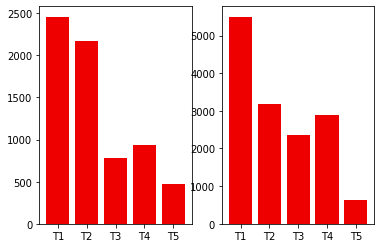

In [24]:
import matplotlib.pyplot as plt
uniq, cnt = np.unique(labs_test,return_counts = True)
plt.subplot(121)
plt.bar(["T1", "T2", "T3", "T4", "T5"], cnt, color="#EE0000",)

uniq, cnt = np.unique(labs_train,return_counts = True)
plt.subplot(122)
plt.bar(["T1", "T2", "T3", "T4", "T5"], cnt, color="#EE0000")

plt.show()

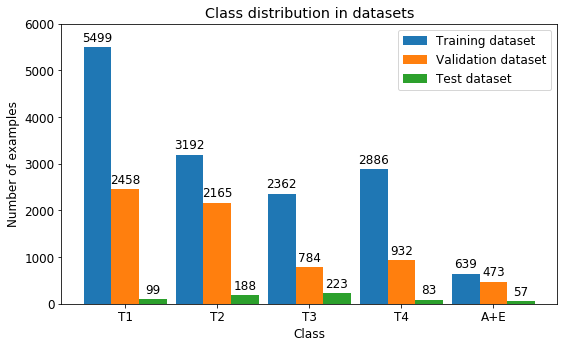

In [64]:
import matplotlib
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,5))
plt.rcParams.update({'font.size': 12})
plt.rc('axes', labelsize=12)
width = 0.30  # the width of the bars
uniq, cnt_train = np.unique(labs_train,return_counts = True)
uniq, cnt_val = np.unique(labs_test,return_counts = True)
uniq, cnt_test = np.unique(labels_testt,return_counts = True)
labels = ["T1", "T2", "T3", "T4", "A+E"]

x = np.arange(len(labels))  # the label locations
rects1 = ax.bar(x - width, cnt_train, width, label='Training dataset')
rects2 = ax.bar(x, cnt_val, width, label='Validation dataset')
rects3 = ax.bar(x + width, cnt_test, width, label='Test dataset')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of examples')
ax.set_ylim((0,6000))
ax.set_title('Class distribution in datasets')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel('Class')
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.savefig("results/class_distr.png")
plt.show()

In [36]:
df = pd.read_csv(os.path.join(os.getcwd(), "results", "Full_experts_check.csv")).set_index("ID")
labels_testt = []
for row in df.iterrows():
    row = row[1]
    labels_testt.append(row["Likely type"]-1)

In [37]:
labels_testt

[0,
 1,
 1,
 0,
 2,
 1,
 2,
 2,
 1,
 3,
 2,
 2,
 1,
 1,
 3,
 2,
 2,
 2,
 2,
 4,
 0,
 1,
 0,
 1,
 2,
 2,
 1,
 2,
 1,
 4,
 2,
 1,
 1,
 1,
 1,
 1,
 3,
 2,
 1,
 1,
 2,
 2,
 2,
 3,
 1,
 2,
 1,
 1,
 2,
 1,
 2,
 2,
 3,
 1,
 1,
 0,
 2,
 2,
 2,
 2,
 4,
 2,
 2,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 3,
 3,
 1,
 3,
 3,
 3,
 3,
 1,
 2,
 2,
 3,
 1,
 2,
 0,
 2,
 1,
 1,
 3,
 1,
 1,
 2,
 1,
 2,
 2,
 2,
 0,
 2,
 1,
 2,
 1,
 0,
 2,
 2,
 3,
 0,
 2,
 2,
 1,
 2,
 1,
 2,
 3,
 2,
 2,
 3,
 1,
 1,
 0,
 2,
 2,
 3,
 2,
 2,
 0,
 1,
 1,
 2,
 1,
 2,
 2,
 2,
 4,
 2,
 0,
 1,
 1,
 3,
 2,
 1,
 1,
 2,
 1,
 1,
 2,
 2,
 0,
 1,
 0,
 1,
 0,
 1,
 2,
 1,
 1,
 0,
 1,
 2,
 1,
 2,
 2,
 3,
 0,
 0,
 0,
 2,
 1,
 0,
 2,
 0,
 2,
 1,
 2,
 2,
 1,
 2,
 2,
 1,
 4,
 1,
 0,
 4,
 1,
 2,
 4,
 2,
 0,
 2,
 4,
 3,
 2,
 2,
 3,
 0,
 0,
 2,
 2,
 2,
 1,
 1,
 0,
 2,
 3,
 3,
 2,
 1,
 3,
 2,
 2,
 2,
 2,
 1,
 0,
 2,
 2,
 1,
 2,
 1,
 0,
 1,
 4,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 1,
 2,
 2,
 0,
 2,
 4,
 1,
 0,
 2,
 4,
 0,
 3,
 0,
 2,
 0,
 1,
 2,
 2,
 3,
 0,
 1,
 2,


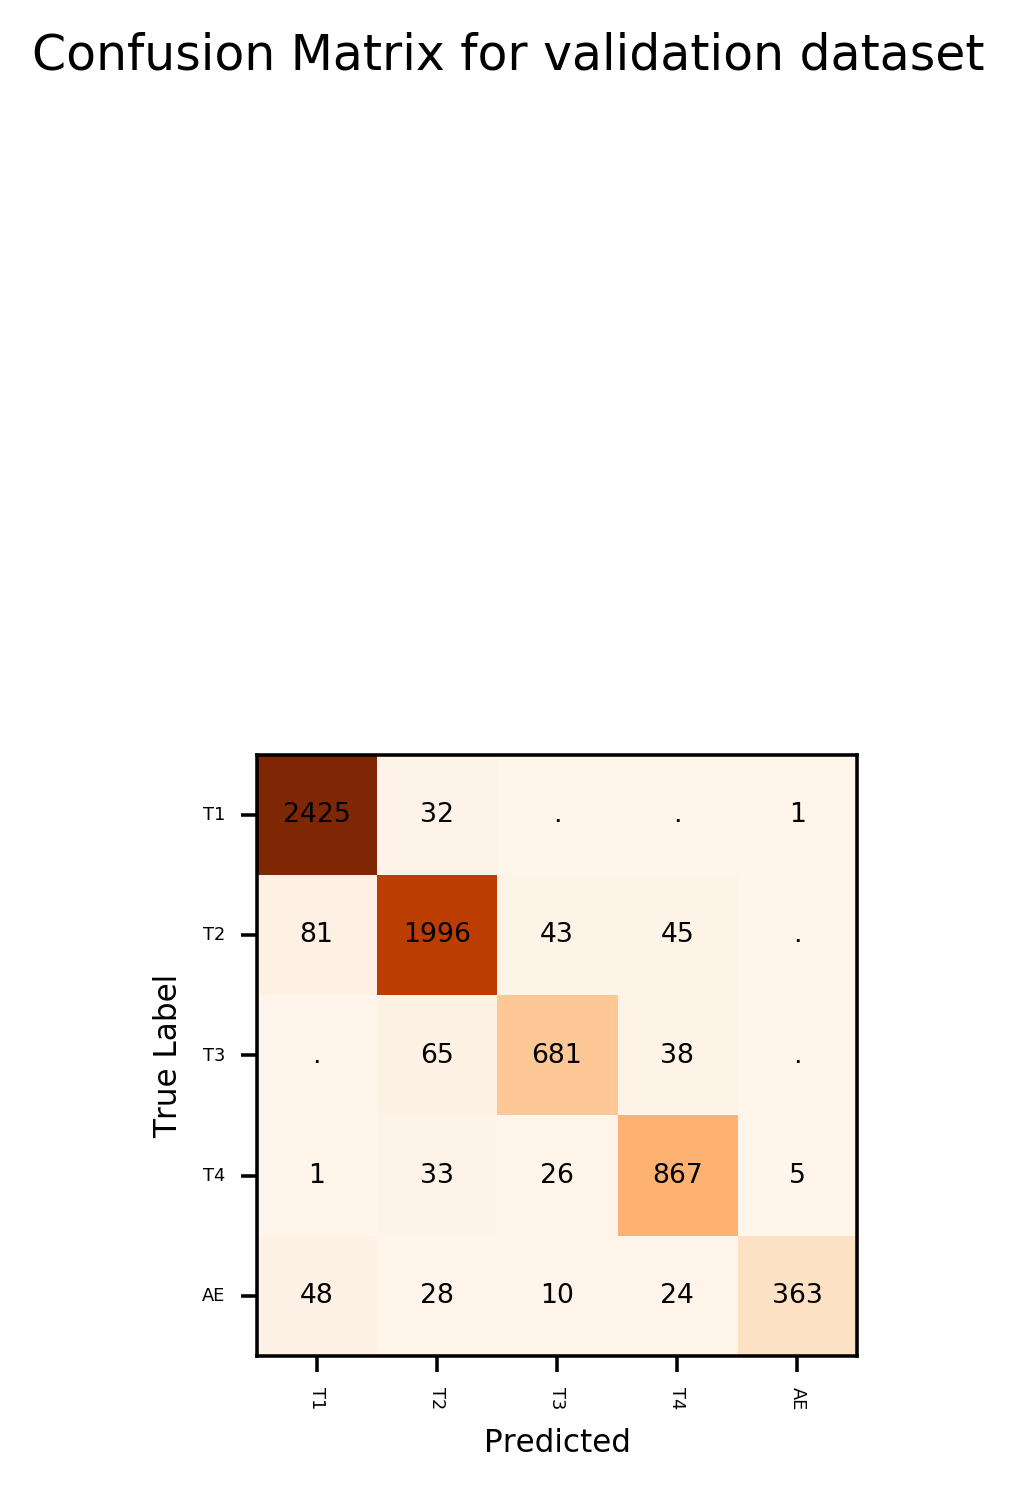

In [93]:
from utils import plot_confusion_matrix
train_dataset.set_parameters(siamese=False,
                            multilabel=False,
                            include_artificial_ae=False,
                            transforms=None)
test_dataset.set_parameters(siamese=False,
                            multilabel=False,
                            include_artificial_ae=False,
                            transforms=None)
test_loader = DataLoader(test_dataset, 1024, shuffle=False, num_workers=0)
train_loader = DataLoader(train_dataset, 1024, shuffle=False, num_workers=0)
labs_train = []
labs_test = []

for i, data in enumerate(test_loader, 0):
    labels = data['label']
    labs_test += labels.tolist()


for i, data in enumerate(train_loader, 0):
    labels = data['label']
    labs_train += labels.tolist()
    
size = 160
plt.rcParams.update({'font.size': size})
plt.rc('axes', labelsize=size)
plt.rc('xtick', labelsize=size)
plt.rc('ytick', labelsize=size)    
plt.rc('axes', labelsize=size) 
class_dict = {0: "T1", 1: "T2", 2: "T3", 3: "T4", 4: "AE"}
labs = [class_dict[a] for a in labs_test]
preds = [class_dict[a] for a in output_dataframe_dict["2020-10-12_Training_ResNet_1"]]
plot = plot_confusion_matrix(labs, preds, [class_dict[key] for key in class_dict.keys()])
plot.suptitle('Confusion Matrix for validation dataset', fontsize=11)
plt.savefig("results/conf_val.png")

In [33]:
labs_test

[[0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 1.0, 0.0, 0.0],
 [0.0, 0.0, 1.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0

In [52]:
model_input = [ICP_full.to(device)]
labels = data['label'].to(device)
model_input = input_preprocessing(model_input)
outputs = model(*model_input)
predicted = output_to_pred_fcn(outputs)

In [55]:
predicted

array([0, 2, 1, 0, 2, 1, 3, 3, 1, 3, 1, 2, 3, 3, 3, 2, 2, 2, 2, 4, 0, 1,
       0, 1, 2, 3, 0, 1, 4, 4, 3, 1, 1, 1, 1, 1, 3, 2, 1, 1, 2, 2, 2, 3,
       1, 3, 0, 1, 3, 1, 2, 3, 3, 1, 1, 0, 2, 2, 2, 3, 4, 4, 2, 4, 3, 1,
       1, 0, 2, 1, 1, 3, 3, 4, 3, 3, 3, 3, 1, 2, 3, 4, 1, 1, 0, 2, 0, 1,
       3, 1, 1, 2, 1, 2, 2, 2, 0, 2, 3, 2, 1, 0, 2, 2, 3, 0, 3, 2, 1, 2,
       1, 2, 3, 2, 2, 3, 3, 1, 0, 2, 2, 3, 2, 2, 0, 1, 1, 3, 1, 3, 2, 2,
       4, 2, 0, 1, 1, 3, 2, 1, 1, 2, 1, 1, 2, 2, 0, 1, 0, 1, 0, 1, 2, 1,
       1, 0, 1, 2, 1, 2, 2, 3, 0, 3, 0, 2, 1, 0, 3, 0, 2, 1, 2, 2, 1, 2,
       3, 1, 4, 1, 0, 2, 1, 2, 4, 2, 0, 3, 4, 3, 2, 2, 3, 0, 1, 2, 2, 1,
       1, 2, 0, 2, 3, 3, 2, 0, 3, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 0, 1,
       0, 1, 2, 1, 3, 1, 3, 2, 1, 2, 2, 0, 2, 4, 3, 0, 2, 4, 0, 3, 0, 2,
       0, 1, 2, 2, 3, 0, 1, 2, 2, 3, 2, 1, 3, 0, 0, 1, 3, 2, 1, 0, 3, 3,
       2, 1, 2, 3, 3, 3, 0, 1, 4, 1, 2, 2, 1, 1, 3, 3, 2, 1, 3, 2, 2, 0,
       2, 3, 2, 1, 3, 3, 3, 2, 0, 0, 2, 4, 2, 3, 3,

In [60]:
df["Likely type"]

1

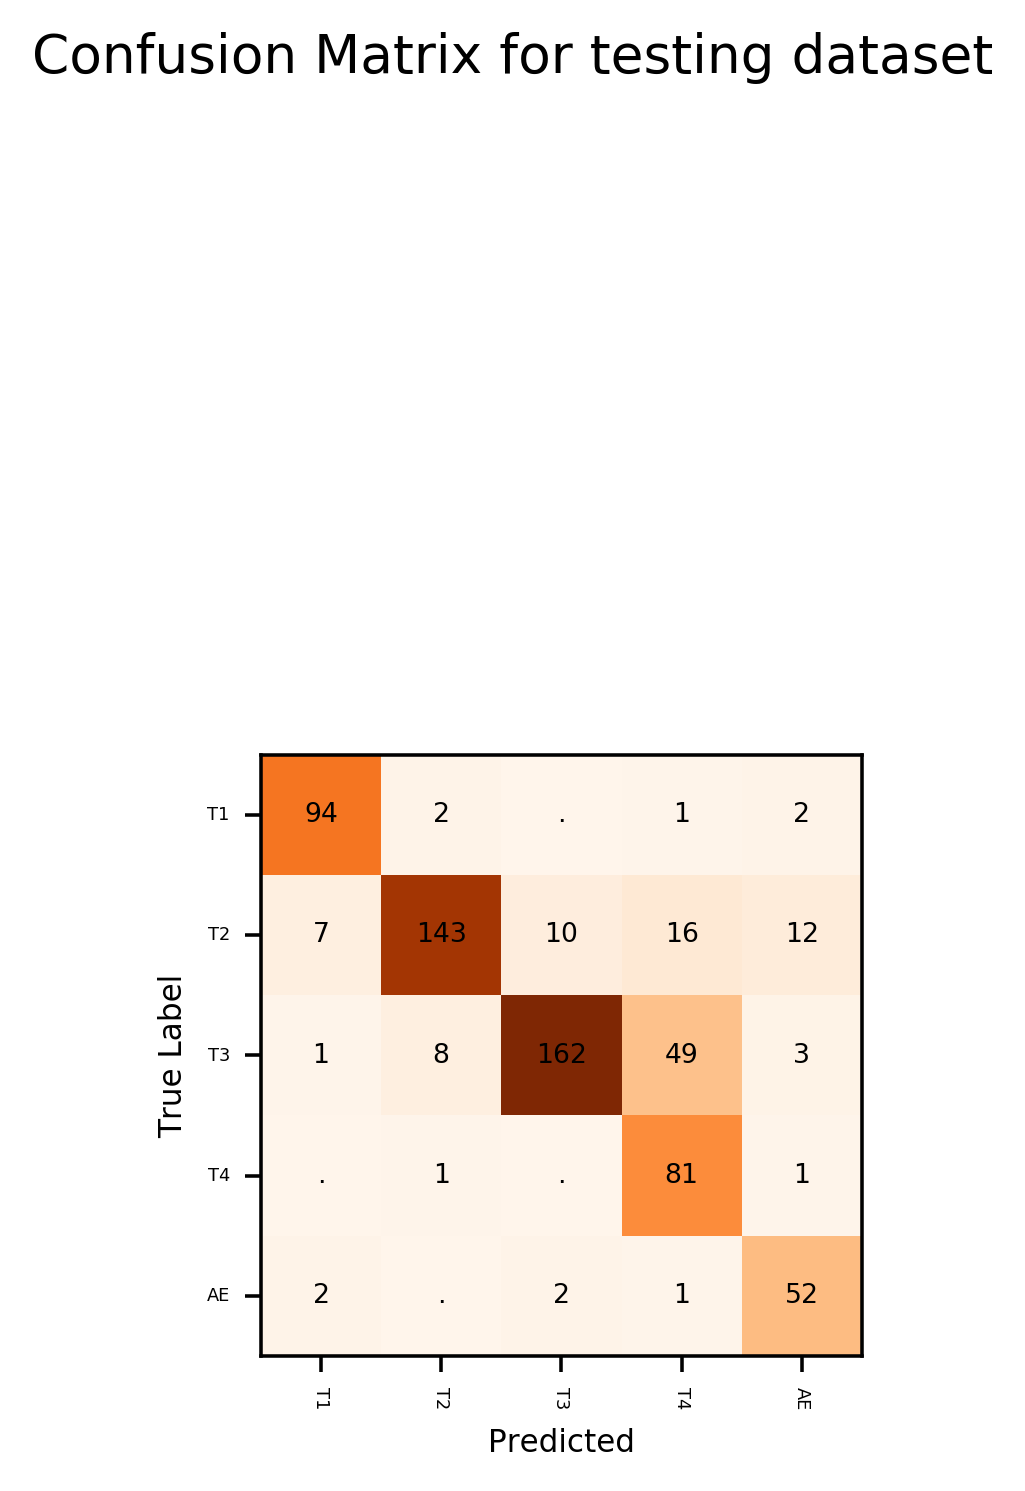

In [94]:
size = 160
plt.rcParams.update({'font.size': size})
plt.rc('axes', labelsize=size)
plt.rc('xtick', labelsize=size)
plt.rc('ytick', labelsize=size)    
plt.rc('axes', labelsize=size)  
class_dict = {0: "T1", 1: "T2", 2: "T3", 3: "T4", 4: "AE"}
labs = [class_dict[a-1] for a in df["Likely type"]]
preds = [class_dict[a] for a in predicted]
plot = plot_confusion_matrix(labs, preds, [class_dict[key] for key in class_dict.keys()])
plot.suptitle('Confusion Matrix for testing dataset', fontsize=12)
plt.savefig("results/conf_test.png")

In [81]:
from sklearn.metrics import classification_report
print(classification_report([pr+1 for pr in predicted], df["Likely type"]))

              precision    recall  f1-score   support

           1       0.95      0.90      0.93       104
           2       0.76      0.93      0.84       154
           3       0.73      0.93      0.82       174
           4       0.98      0.55      0.70       148
           5       0.91      0.74      0.82        70

    accuracy                           0.82       650
   macro avg       0.86      0.81      0.82       650
weighted avg       0.85      0.82      0.81       650



In [82]:

print(classification_report(output_dataframe_dict["2020-10-12_Training_ResNet_1"], labs_test))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      2555
           1       0.92      0.93      0.92      2154
           2       0.87      0.90      0.88       760
           3       0.93      0.89      0.91       974
           4       0.77      0.98      0.86       369

    accuracy                           0.93      6812
   macro avg       0.89      0.93      0.91      6812
weighted avg       0.93      0.93      0.93      6812

